In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from EnvLibs import getEnvConfig, createEnv, visualizeEnvConfig, PolicyDemoAdaptiveAlpha, PolicySimulator

In [2]:
configIdx = 0
params = getEnvConfig(configIdx)
visualizeEnvConfig(params)
env = createEnv(params)

Environment Configuration
Number of Users:        4
Window Length:          20
Dataflow:               thumb_fr
Resource Bar:           4
Bandwidth:              40
M List:                 [2, 3]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10


avg_reward_mdp: 0.005770291092982859, avg_reward_adaptive: 0.024032663576540932


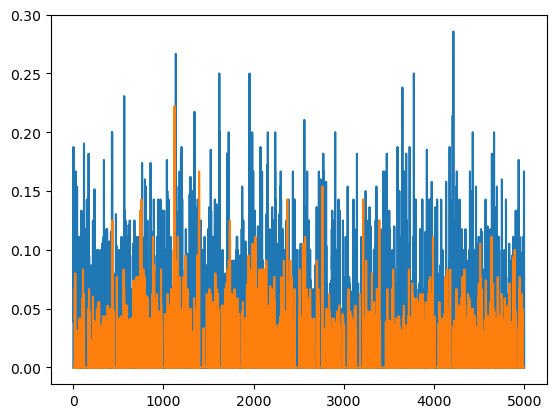

In [3]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernel_config{configIdx}.pkl', 'rb') as f:
    mdpPolicy = pickle.load(f)
adaptiveAlphaPolicy = PolicyDemoAdaptiveAlpha(params)

# ==== Prepare Simulator====
policySimulator = PolicySimulator(mdpPolicy, env)
rewardRecord_mdp = policySimulator.runSimulation(mdpPolicy, num_epochs=5000, mode="test", type="data")
rewardRecord_adaptive = policySimulator.runSimulation(adaptiveAlphaPolicy, num_epochs=5000, mode="test", type="data")

print(f"avg_reward_mdp: {np.mean(rewardRecord_mdp)}, avg_reward_adaptive: {np.mean(rewardRecord_adaptive)}")

plt.plot(rewardRecord_adaptive, label="adaptive")
plt.plot(rewardRecord_mdp)
plt.show()